# AO/DAPI % viability-vs-T2

**Nonlinear regression analysis between AO/DAPI % viability and proliferation infection point.**

In [1]:
import numpy as np
import scipy.optimize as optim
import math
import os,sys
import pandas as pd
import copy
import scipy.stats as st
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib import rcParams

import random as rand

import scipy.stats as st

from sklearn.metrics import auc

import copy

In [2]:
def nonlinear(x,a,b):
    return (a*(np.power(x,b)))

**Read viability and T2 inflection points**

In [3]:
cwd = os.getcwd()
data_directory = './data/AODAPI'
os.chdir(data_directory)

aodapi_T2 = pd.read_csv('AODAPI-T2paired-Day1.csv')

column_names = list(aodapi_T2)

aodapis, t2s, ths = {}, {}, {}

for c in column_names:
    if 'T2' in c:
        t2s[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        
    if 'AODAPI' in c:
        aodapis[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        
    if 'TH' in c:
        ths[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]

**Fit AO/DAPI % Viability-vs-T2**

In [4]:
x, y = [], []

for c in aodapis.keys():
    x += aodapis[c]

for c in t2s.keys():
    y += t2s[c]
    
dof = len(x) - 2
    
x = np.array(x)/100
y = np.array(y)
    
result = st.linregress(np.log(x),np.log(y),alternative='two-sided')

results = optim.curve_fit(nonlinear,x,y,full_output=True)

popt, pcov = results[0], results[1]

mean_aodapi = np.linspace(40,100,250)
t2 = nonlinear(0.01*mean_aodapi,popt[0],popt[1])

fitname = r'T2 = ' + str(round(popt[0],2)) + '(AO/DAPI/100)$^{'+ str(round(popt[1],1)) + '}$'

**Residual sum of squares:**

In [5]:
residual = nonlinear(x,popt[0],popt[1]) - y

norm_RSS = math.sqrt(np.dot(residual,residual)/(x.shape[0]-2))

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

**Compute the 95 % confidence interval (CI) for the regression analysis and the 95 % prediction bound(PB) of the fit.**

In [6]:
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)

n_samples = 10000

s_is, i_is = [], []

cit2_up = np.zeros(shape=mean_aodapi.shape)
cit2_low = np.zeros(shape=mean_aodapi.shape)

pbt2_up = np.zeros(shape=mean_aodapi.shape)
pbt2_low = np.zeros(shape=mean_aodapi.shape)

sigmat2_up = np.zeros(shape=mean_aodapi.shape)
sigmat2_low = np.zeros(shape=mean_aodapi.shape)

t2 = np.zeros(shape=mean_aodapi.shape)
effective_sigma = np.zeros(shape=mean_aodapi.shape)

for i in range(0,mean_aodapi.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(nonlinear(0.01*mean_aodapi[i],a_sample,b_sample))
        
    t2[i] = nonlinear(0.01*mean_aodapi[i],popt[0],popt[1])
        
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    pbt2_low[i], pbt2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    cit2_low[i], cit2_up[i] = t2[i] - sigma*ts, t2[i] + sigma*ts
    
    sigmat2_low[i], sigmat2_up[i] = t2[i] - effective_sigma[i], t2[i] + effective_sigma[i]

**Plot nonlinear regression analysis result**

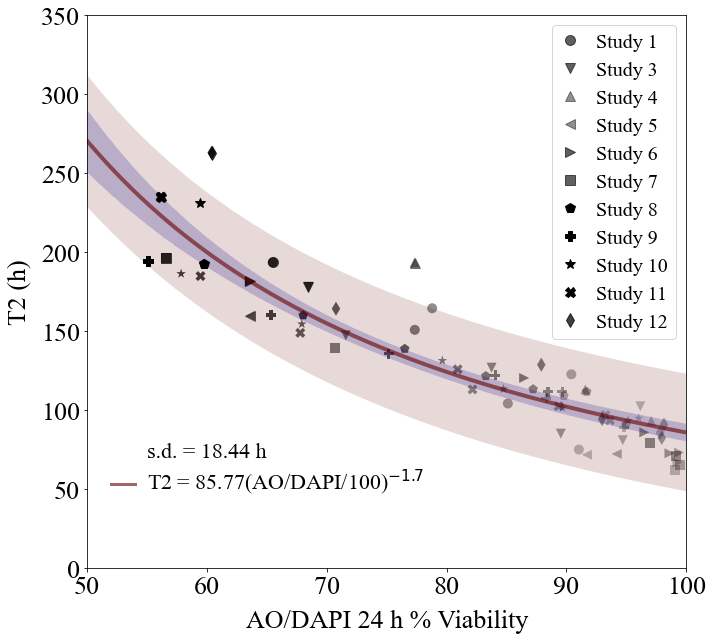

In [7]:
all_markers = ["o","v","^","<",">","s","p","P","*","X","d","D"]

studies = ['Study1','Study3','Study4','Study5','Study6','Study7','Study8','Study9','Study10','Study11','Study12']

fig, axs = plt.subplots(figsize=(10,9))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

mi = 0

for s in studies:
    labelname = s.replace('Study','Study ')
    
    alpha_s = 0.75*np.array(ths[s+'_TH'])/60.0 + 0.25
    
    plt.scatter(aodapis[s+'_AODAPI'],t2s[s+'_T2'],marker=all_markers[mi],s=100,color='black',alpha=alpha_s,linewidth=0)

    plt.plot(aodapis[s+'_AODAPI'][-1],t2s[s+'_T2'][-1],marker=all_markers[mi],ms=10,color='black',alpha=alpha_s[-1],linewidth=0,label=labelname)

    mi += 1
    
plt.plot(mean_aodapi,t2,linewidth=4,color='#660000',alpha=0.6)

plt.fill_between(mean_aodapi,pbt2_up,pbt2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(mean_aodapi,cit2_up,cit2_low,alpha=0.2,color='#000088',linewidth=0.0)

plt.xticks(size=26)
plt.yticks(size=26)  
plt.xlabel(r'AO/DAPI 24 h % Viability',size=26,labelpad=10)
plt.ylabel(r'T2 (h)',size=26,rotation=90,labelpad=10)
plt.xlim(50,100)
plt.ylim(0,350)

plt.plot(np.linspace(52,54,2),53*np.ones(2,),color='#660000',alpha=0.6,lw=3)

plt.text(55,70,RSS_text,fontsize=22)
plt.text(55,50,fitname,fontsize=22)

plt.legend(frameon=True,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper right')

plt.tight_layout()

#plt.savefig('AODAPI_24h-vs-T2.png',dpi=300)

In [8]:
#test_t2s = [96,108,120,132,144,156,168,180,192,204,216,228,240,252,264]
test_t2s = [96,120,144,168,192,216,240,264]
#test_t2s = [96,144,192,240]

test_t2s.reverse()

cutoff_probs = {}
pdfs = {}
cdfs = {}

for k in test_t2s:
    cutoff_probs[k] = np.zeros(shape=mean_aodapi.shape)
    pdfs[k] = np.zeros(shape=mean_aodapi.shape)
    cdfs[k] = np.zeros(shape=mean_aodapi.shape)
    
responses = np.zeros(shape=(len(test_t2s),mean_aodapi.shape[0]))

j = 0

for k in test_t2s:
    for i in range(0,mean_aodapi.shape[0]):
        cutoff_probs[k][i] = st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        pdfs[k][i] = st.t.pdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        
    pdfs[k] *= 1.0/np.sum(pdfs[k])
    x = copy.deepcopy(pdfs[k][::-1])
    sum_x = np.array([np.sum(x[m:]) for m in range(0,pdfs[k].shape[0])])
    
    cdfs[k] = sum_x[::-1]
    
    responses[j,:] = pdfs[k]
    
    j += 1

Text(0.5, 0, 'AO/DAPI 24 h % Viability')

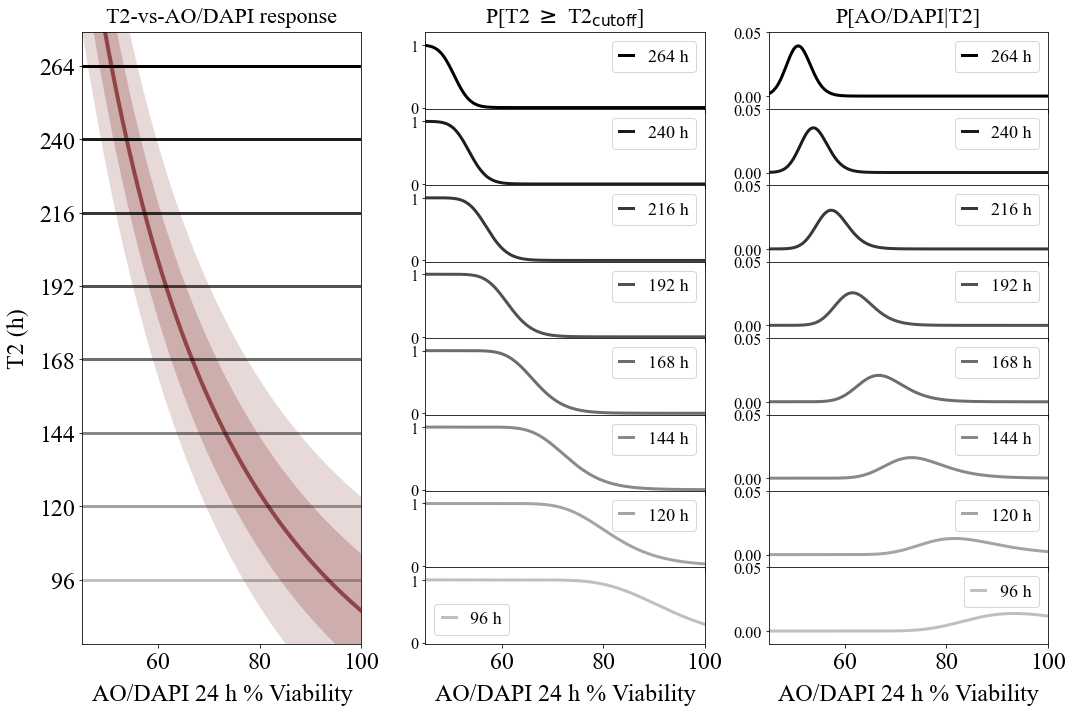

In [9]:
fig = plt.figure(tight_layout=True,figsize=(15,10))
gs = fig.add_gridspec(len(test_t2s),3, hspace=0)

ax = fig.add_subplot(gs[:,0])
ax.plot(mean_aodapi,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)
ax.fill_between(mean_aodapi,pbt2_up,pbt2_low,alpha=0.15,color='#660000',linewidth=0.0)
ax.fill_between(mean_aodapi,sigmat2_up,sigmat2_low,alpha=0.2,color='#660000',linewidth=0.0)

ax.set_title(r'T2-vs-AO/DAPI response',size=22,pad=10)

ax.tick_params(axis='both',labelsize=24)
ax.set_yticks(test_t2s)
ax.set_xlabel(r'AO/DAPI 24 h % Viability',size=24,labelpad=10)
ax.set_ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
ax.set_ylim(75,275)
ax.set_xlim(45,100)

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_aodapi,t*np.ones(shape=mean_aodapi.shape[0]),color='black',lw=3,alpha=_alpha)

for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,1])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_aodapi,cutoff_probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylim(-0.02,1.2)
    ax.set_xlim(45,100)
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title(r'P[T2 $\geq$ T2$_{\mathrm{cutoff}}$]',size=22,pad=10)
        
ax.set_xlabel(r'AO/DAPI 24 h % Viability',size=24,labelpad=10)
        
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,2])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_aodapi,pdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    
    ax.tick_params(axis='y',labelsize=12)
    ax.set_xlim(45,100)
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.set_ylim(-0.01,0.05)
    
    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title('P[AO/DAPI|T2]',size=22,pad=10)
          
ax.set_xlabel(r'AO/DAPI 24 h % Viability',size=24,labelpad=10)

#plt.savefig('AODAPI-T2-probabilities-combined-s10000.png',dpi=300)

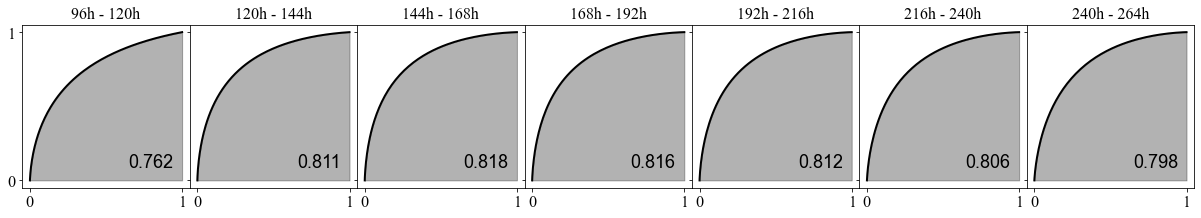

In [10]:
wd = 3

l = int((len(test_t2s)-1)*wd)

fig = plt.figure(figsize=(l,wd))
gs = fig.add_gridspec(ncols=len(test_t2s)-1, nrows=1, wspace=0)

axs = gs.subplots(sharex=True,sharey=True)

all_aucs = []

test_t2s = test_t2s[::-1]

wf = open('auc_summary.csv','w')
print('Time interval,AUC',file=wf)

for k in range(0,len(test_t2s)-1):    
    dx = cdfs[test_t2s[k]][::-1]
    dy = cdfs[test_t2s[k+1]][::-1]
    
    all_aucs.append(auc(dx,dy))
    
    label_text = str(round(all_aucs[-1],3))
    
    axs[k].plot(dx,dy,lw=2,color='black',label=label_text)
    axs[k].fill_between(dx,dy,0,color='black',alpha=0.3)#,label=str(test_t2s[k])+' h',alpha=_alpha)
    axs[k].set_xticks((0,1))
    axs[k].set_yticks((0,1))
    axs[k].tick_params(axis='both',labelsize=16)
    axs[k].legend(frameon=False,prop={'size': 18,'family':'Arial'},markerscale=1.0,handlelength=0.0,loc='lower right')
    axs[k].set_title(str(test_t2s[k])+'h - '+str(test_t2s[k+1])+'h',fontsize=16)
        
    output_string = str(test_t2s[k])+'h - '+str(test_t2s[k+1])+'h'
    output_string += ',' + label_text
    
    print(output_string,file=wf)
    
wf.close()

**AO/DAPI Day 0 % viability.**

In [11]:
aodapi_T2_d0 = pd.read_csv('AODAPI-T2paired-Day0.csv')

column_names = list(aodapi_T2_d0)

aodapis_d0, t2s_d0 = {}, {}

for c in column_names:
    if 'T2' in c:
        t2s_d0[c] = [round(x,2) for x in aodapi_T2_d0[c] if math.isnan(x) == False]
        
    if 'AODAPI' in c:
        aodapis_d0[c] = [round(x,2) for x in aodapi_T2_d0[c] if math.isnan(x) == False]
            
    if 'TH' in c:
        ths[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]

In [12]:
all_aodapis, all_t2s = [], []

for s in studies:
    all_aodapis += aodapis_d0[s+'_AODAPI']
    all_t2s += t2s_d0[s+'_T2']

In [13]:
result = st.linregress(all_aodapis,all_t2s,alternative='two-sided')
r2 = str(round(result.rvalue**2,3))

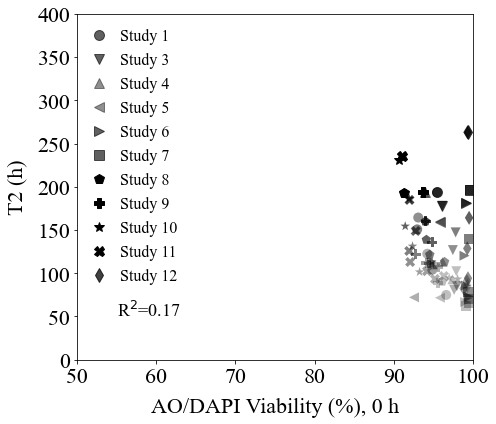

In [14]:
all_markers = ["o","v","^","<",">","s","p","P","*","X","d","D"]

studies = ['Study1','Study3','Study4','Study5','Study6','Study7','Study8','Study9','Study10','Study11','Study12']

fig, axs = plt.subplots(figsize=(7,6))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

mi = 0

for s in studies:
    labelname = s.replace('Study','Study ')
    
    alpha_s = 0.75*np.array(ths[s+'_TH'])/60.0 + 0.25
    
    plt.scatter(aodapis_d0[s+'_AODAPI'],t2s_d0[s+'_T2'],marker=all_markers[mi],s=100,color='black',alpha=alpha_s,linewidth=0)

    plt.plot(aodapis_d0[s+'_AODAPI'][-1],t2s[s+'_T2'][-1],marker=all_markers[mi],ms=10,color='black',alpha=alpha_s[-1],linewidth=0,label=labelname)

    mi += 1
    
plt.xticks(size=22)
plt.yticks(size=22)  
plt.xlabel(r'AO/DAPI Viability (%), 0 h',size=22,labelpad=10)
plt.ylabel(r'T2 (h)',size=22,rotation=90,labelpad=10)
plt.xlim(50,100)
plt.ylim(0,400)
plt.text(55,50,r'R$^2$='+r2,fontsize=18)

plt.legend(frameon=False,prop={'size': 16,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper left')
plt.tight_layout()